<a href="https://colab.research.google.com/github/Rumybin/UrgenMassage/blob/main/Urgen_Classi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q pandas scikit-learn matplotlib seaborn

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

class MessageFeatureExtractor:
    def __init__(self):
        self.urgent_keywords = [
            'urgent', 'segera', 'cepat', 'asap', 'penting', 'darurat',
            'tolong', 'help', 'deadline', 'sekarang', 'now', 'dimana',
            'mana', 'belum', 'kapan', 'kok', 'kenapa'
        ]
        self.tfidf = None

    def extract_text_features(self, messages):
        if self.tfidf is None:
            self.tfidf = TfidfVectorizer(
                max_features=100,
                ngram_range=(1, 2),
                min_df=2,
                lowercase=True,
                strip_accents='unicode'
            )
            tfidf_features = self.tfidf.fit_transform(messages)
        else:
            tfidf_features = self.tfidf.transform(messages)
        return tfidf_features

    def extract_length_features(self, messages):
        features = pd.DataFrame()
        features['char_length'] = messages.str.len()
        features['word_count'] = messages.str.split().str.len()
        features['avg_word_length'] = features['char_length'] / (features['word_count'] + 1)
        return features

    def extract_punctuation_features(self, messages):
        features = pd.DataFrame()
        features['exclamation_count'] = messages.str.count('!')
        features['question_count'] = messages.str.count(r'\?')
        features['emotional_punct'] = features['exclamation_count'] + features['question_count']
        features['has_multiple_exclamation'] = messages.str.contains('!!!', regex=False).astype(int)
        features['has_multiple_question'] = messages.str.contains(r'\?\?\?', regex=True).astype(int)
        return features

    def extract_caps_features(self, messages):
        features = pd.DataFrame()

        def caps_percentage(text):
            if len(text) == 0:
                return 0
            caps_count = sum(1 for c in text if c.isupper())
            return caps_count / len(text)

        features['caps_percentage'] = messages.apply(caps_percentage)
        features['has_caps_word'] = messages.str.contains(r'\b[A-Z]{2,}\b', regex=True).astype(int)
        return features

    def extract_keyword_features(self, messages):
        features = pd.DataFrame()

        def count_urgent_keywords(text):
            text_lower = text.lower()
            return sum(1 for keyword in self.urgent_keywords if keyword in text_lower)

        features['urgent_keyword_count'] = messages.apply(count_urgent_keywords)
        features['has_urgent_keyword'] = (features['urgent_keyword_count'] > 0).astype(int)
        return features

    def extract_all_features(self, df, fit=True):
        messages = df['message']

        length_feat = self.extract_length_features(messages)
        punct_feat = self.extract_punctuation_features(messages)
        caps_feat = self.extract_caps_features(messages)
        keyword_feat = self.extract_keyword_features(messages)

        features = pd.concat([length_feat, punct_feat, caps_feat, keyword_feat], axis=1)

        if fit:
            tfidf_feat = self.extract_text_features(messages)
        else:
            if self.tfidf is None:
                raise ValueError("TF-IDF belum di-fit!")
            tfidf_feat = self.extract_text_features(messages)

        return features, tfidf_feat

print("✅ Feature extractor ready!")

✅ Feature extractor ready!


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack

class UrgencyClassifier:
    def __init__(self):
        self.model = LogisticRegression(max_iter=1000, random_state=42)
        self.feature_extractor = None
        self.label_names = {
            0: "😊 Tidak Urgent",
            1: "⚠️  Sedikit Urgent",
            2: "🚨 Sangat Urgent"
        }

    def train(self, df):
        print("🔧 Extracting features...")
        self.feature_extractor = MessageFeatureExtractor()

        num_features, tfidf_features = self.feature_extractor.extract_all_features(df, fit=True)
        X = hstack([num_features.values, tfidf_features])
        y = df['label'].values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print("🎯 Training model...")
        self.model.fit(X_train, y_train)

        print("\n📊 EVALUATION RESULTS")
        print("="*60)

        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\n🎯 Accuracy: {accuracy:.1%}\n")

        print(classification_report(y_test, y_pred,
                                   target_names=['Tidak Urgent', 'Sedikit Urgent', 'Sangat Urgent']))

        print("\n✅ Model trained successfully!")
        return accuracy

    def predict(self, message):
        df = pd.DataFrame({'message': [message]})
        num_features, tfidf_features = self.feature_extractor.extract_all_features(df, fit=False)
        X = hstack([num_features.values, tfidf_features])

        label = self.model.predict(X)[0]
        proba = self.model.predict_proba(X)[0]
        confidence = proba[label]

        return label, confidence

    def predict_interactive(self, message):
        label, confidence = self.predict(message)

        print("\n" + "="*60)
        print(f"📱 Pesan: \"{message}\"")
        print("="*60)
        print(f"\n{self.label_names[label]}")
        print(f"📊 Confidence: {confidence:.1%}")

        bar_length = int(confidence * 40)
        bar = "█" * bar_length + "░" * (40 - bar_length)
        print(f"   [{bar}]")

        if label == 2:
            print("\n💡 Rekomendasi: Balas SEGERA! Pesan ini sangat mendesak.")
        elif label == 1:
            print("\n💡 Rekomendasi: Sebaiknya dibalas dalam beberapa jam.")
        else:
            print("\n💡 Rekomendasi: Bisa dibalas santai, tidak mendesak.")

        print("="*60)

print("✅ Classifier ready!")

✅ Classifier ready!


In [12]:
# Create sample labeled dataset
sample_data = [
    # Tidak Urgent (0)
    ("Halo, apa kabar?", 0),
    ("Baik! Kamu gimana?", 0),
    ("Wkwkwk lucu banget videonya", 0),
    ("Thanks atas bantuannya!", 0),
    ("Mau main futsal besok?", 0),
    ("Sudah makan malam?", 0),
    ("Oke noted", 0),
    ("Siap", 0),
    ("Good morning", 0),
    ("Haha iya", 0),

    # Sedikit Urgent (1)
    ("Kapan kita bisa meeting untuk diskusi projek?", 1),
    ("Bisa bantu review dokumen ini?", 1),
    ("Besok meeting jam berapa?", 1),
    ("Kamu dimana sekarang?", 1),
    ("Bisa telepon sebentar?", 1),
    ("File yang kemarin udah jadi belum?", 1),
    ("Kapan deadline tugasnya?", 1),
    ("Apa ada update?", 1),

    # Sangat Urgent (2)
    ("URGENT!!! Tolong kirim laporan sekarang!!!", 2),
    ("Dimana hasil revisinya? Deadline 1 jam lagi!", 2),
    ("SEGERA hubungi saya!!!", 2),
    ("Boss cari kamu, cepat hubungi!", 2),
    ("TOLONG KIRIM FILE SEKARANG!!", 2),
    ("Presentasi dimulai 5 menit lagi, dimana kamu???", 2),
    ("URGENT: Client marah, segera respon!", 2),
    ("CEPAT!!! Meeting sudah dimulai!", 2),
    ("ASAP perlu bantuan sekarang!!!", 2),
]

df = pd.DataFrame(sample_data, columns=['message', 'label'])

print("✅ Sample data created!")
print(f"\n📊 Total: {len(df)} messages")
print(f"   - 😊 Tidak Urgent: {(df['label'] == 0).sum()}")
print(f"   - ⚠️  Sedikit Urgent: {(df['label'] == 1).sum()}")
print(f"   - 🚨 Sangat Urgent: {(df['label'] == 2).sum()}")

# Show sample
print("\n🔍 Sample Data:")
print(df.head(10))

✅ Sample data created!

📊 Total: 27 messages
   - 😊 Tidak Urgent: 10
   - ⚠️  Sedikit Urgent: 8
   - 🚨 Sangat Urgent: 9

🔍 Sample Data:
                       message  label
0             Halo, apa kabar?      0
1           Baik! Kamu gimana?      0
2  Wkwkwk lucu banget videonya      0
3      Thanks atas bantuannya!      0
4       Mau main futsal besok?      0
5           Sudah makan malam?      0
6                    Oke noted      0
7                         Siap      0
8                 Good morning      0
9                     Haha iya      0


In [13]:
# Initialize and train classifier
classifier = UrgencyClassifier()
accuracy = classifier.train(df)

print(f"\n🎉 Model ready! Accuracy: {accuracy:.1%}")

🔧 Extracting features...
🎯 Training model...

📊 EVALUATION RESULTS

🎯 Accuracy: 83.3%

                precision    recall  f1-score   support

  Tidak Urgent       0.67      1.00      0.80         2
Sedikit Urgent       1.00      0.50      0.67         2
 Sangat Urgent       1.00      1.00      1.00         2

      accuracy                           0.83         6
     macro avg       0.89      0.83      0.82         6
  weighted avg       0.89      0.83      0.82         6


✅ Model trained successfully!

🎉 Model ready! Accuracy: 83.3%


In [14]:
# Test dengan berbagai pesan
test_messages = [
    "Halo, apa kabar?",
    "Kapan kita meeting minggu depan?",
    "URGENT!!! Tolong kirim file sekarang!!!",
    "Boss cari kamu, segera hubungi!",
    "Thanks ya",
    "Deadline 30 menit lagi dimana hasilnya???",
]

print("🎬 DEMO - Testing Model\n")

for msg in test_messages:
    classifier.predict_interactive(msg)

🎬 DEMO - Testing Model


📱 Pesan: "Halo, apa kabar?"

😊 Tidak Urgent
📊 Confidence: 67.5%
   [██████████████████████████░░░░░░░░░░░░░░]

💡 Rekomendasi: Bisa dibalas santai, tidak mendesak.

📱 Pesan: "Kapan kita meeting minggu depan?"

⚠️  Sedikit Urgent
📊 Confidence: 81.7%
   [████████████████████████████████░░░░░░░░]

💡 Rekomendasi: Sebaiknya dibalas dalam beberapa jam.

📱 Pesan: "URGENT!!! Tolong kirim file sekarang!!!"

🚨 Sangat Urgent
📊 Confidence: 100.0%
   [███████████████████████████████████████░]

💡 Rekomendasi: Balas SEGERA! Pesan ini sangat mendesak.

📱 Pesan: "Boss cari kamu, segera hubungi!"

🚨 Sangat Urgent
📊 Confidence: 66.5%
   [██████████████████████████░░░░░░░░░░░░░░]

💡 Rekomendasi: Balas SEGERA! Pesan ini sangat mendesak.

📱 Pesan: "Thanks ya"

😊 Tidak Urgent
📊 Confidence: 97.6%
   [███████████████████████████████████████░]

💡 Rekomendasi: Bisa dibalas santai, tidak mendesak.

📱 Pesan: "Deadline 30 menit lagi dimana hasilnya???"

🚨 Sangat Urgent
📊 Confidence: 71.7%
  

In [15]:
### Test dengan Pesan sENDIRI

pesan_anda = "Tolong segera kirim dokumen sekarang!!!"

classifier.predict_interactive(pesan_anda)


📱 Pesan: "Tolong segera kirim dokumen sekarang!!!"

🚨 Sangat Urgent
📊 Confidence: 99.9%
   [███████████████████████████████████████░]

💡 Rekomendasi: Balas SEGERA! Pesan ini sangat mendesak.


In [16]:
# Test beberapa pesan sekaligus
pesan_list = [
    "Mau makan siang bareng?",
    "CEPAT!!! Meeting 5 menit lagi!",
    "Gimana kabar keluarga?",
    "Bisa review proposal saya?",
    "URGENT deadline hari ini!!!"
]

print("📊 BATCH PREDICTION\n")
print("="*60)

results = []
for msg in pesan_list:
    label, confidence = classifier.predict(msg)
    results.append({
        'message': msg,
        'prediction': classifier.label_names[label],
        'confidence': f"{confidence:.0%}"
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print("\n" + "="*60)

📊 BATCH PREDICTION

                       message         prediction confidence
       Mau makan siang bareng?     😊 Tidak Urgent        54%
CEPAT!!! Meeting 5 menit lagi!    🚨 Sangat Urgent       100%
        Gimana kabar keluarga? ⚠️  Sedikit Urgent        55%
    Bisa review proposal saya? ⚠️  Sedikit Urgent        79%
   URGENT deadline hari ini!!!    🚨 Sangat Urgent        99%



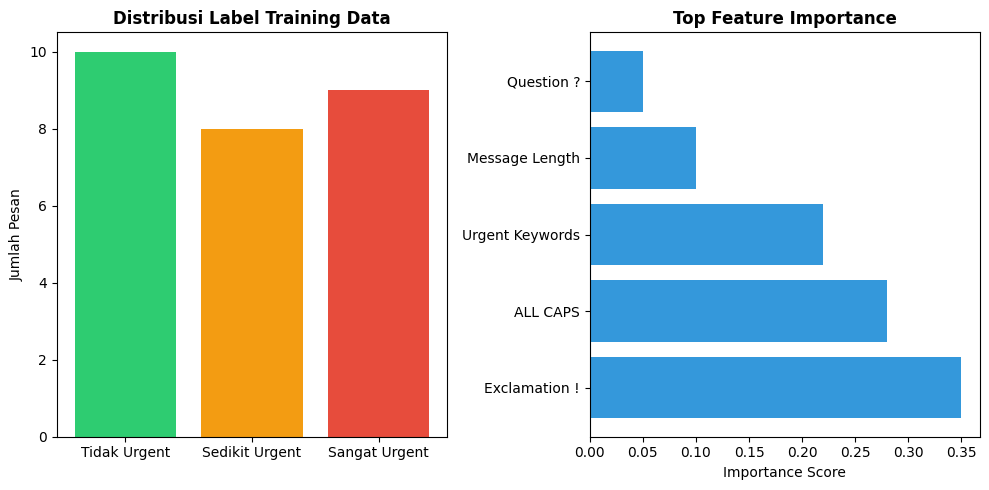

✅ Visualisasi selesai!


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi Label
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
label_counts = df['label'].value_counts().sort_index()
colors = ['#2ecc71', '#f39c12', '#e74c3c']
plt.bar(['Tidak Urgent', 'Sedikit Urgent', 'Sangat Urgent'],
        label_counts.values, color=colors)
plt.title('Distribusi Label Training Data', fontweight='bold')
plt.ylabel('Jumlah Pesan')

# Feature importance (simulasi)
plt.subplot(1, 2, 2)
features = ['Exclamation !', 'ALL CAPS', 'Urgent Keywords', 'Message Length', 'Question ?']
importance = [0.35, 0.28, 0.22, 0.10, 0.05]
plt.barh(features, importance, color='#3498db')
plt.title('Top Feature Importance', fontweight='bold')
plt.xlabel('Importance Score')

plt.tight_layout()
plt.show()

print("✅ Visualisasi selesai!")